<a href="https://colab.research.google.com/github/david-levin11/alaska_verification/blob/main/NBM_Version_Compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**NBM Data Plotter - 6-Panel**
**V1.23** - Steven Fleegel (steven.fleegel@noaa.gov)

This program is designed to fetch NBM percentile data for a specific model run and forecast hour. It will plot the percenitles as a 6-Panel plot.

ToDo: Update the Cities to use the AWIPS cities file and progressive zoom factor

**Update** - David Levin (david.levin@noaa.gov) Arctic Testbed & Proving Ground

Added ability to compare the experimental version of the NBM with the current operational version now that the experimental data is available on the NODD.

**Data Availability:** <br>
NBM 4.x: 5/18/2020 to Present <br>
NBM 5.0 (experimental): 7/11/2025 to Present

## **Run this to download, install, and import the appropriate packages.**  
This first cell will take around a minute to run and get everything ready for us to download the data and make the image(s).

In [55]:
# @title
# Install the packages needed for this notebook.
!pip install -q eccodes==2.38.3 --progress-bar off ## Fixes issue with ecCodes 2.39.0 and Herbie causing Google Colab to crash
!pip install -q cartopy contextily pyepsg xesmf netCDF4 herbie-data==2024.8.0 metpy eccodes --progress-bar off
!pip install -q pygrib

## Imports

from herbie import Herbie
#from toolbox import EasyMap, pc
#from paint.standard2 import cm_tmp
import pandas as pd
import pygrib
from datetime import datetime, timedelta


import requests
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Downlaod and Import shapefiles
import cartopy.io.shapereader as shpreader
import os
import geopandas as gpd
from shapely.geometry import box
from urllib.request import urlretrieve

import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
from copy import deepcopy
#import xoak

from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo
import metpy.calc as mpcalc
from metpy.units import units

# Set Variables that shouldn't be reset with the script
marineZ_dom = None
marineZ_map_extent = [0,0,0,0]

## Make Folders to store data
!mkdir /content/shp

print ("Install & Import Done!")

mkdir: cannot create directory ‘/content/shp’: File exists
Install & Import Done!


##**Download Data, prep the data, and create the image**

Make your selections for the model, data, time, etc for the image. When you're ready, click the play button to make your image. The image will show up below and can also be downloaded from the folder to the left.

The first run will take the longest, as it needs to download map data for the background.

NBM Init Date: 2025-07-12 00:00:00
NBM Valid Date: 2025-07-15 12:00:00
NBM QMD forecast hour is 84
https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend.20250712/00/
https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend.20250712/00/
Field is: 10%
blend.t00z.qmd.f084.ak.grib2
blend.t00z.qmd.20250712_0020250712_00f084.ak.QPF-Pctl_10_subset.grib2
https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend.20250712/00/qmd/blend.t00z.qmd.f084.ak.grib2
:APCP:surface:36-84 hour acc fcst:10% level
   > Downloading a subset of NBM gribs
      ✅ Downloaded [1] fields → nbm/blend.t00z.qmd.20250712_0020250712_00f084.ak.QPF-Pctl_10_subset.grib2
Field is: 50%
blend.t00z.qmd.f084.ak.grib2
blend.t00z.qmd.20250712_0020250712_00f084.ak.QPF-Pctl_50_subset.grib2
https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend.20250712/00/qmd/blend.t00z.qmd.f084.ak.grib2
:APCP:surface:36-84 hour acc fcst:50% level
   > Downloading a subset of NBM gribs
      ✅ Downloaded [1] fields → nbm/blend.t00z.qmd.20250712_0020250712_00f084.ak.QPF-Pc

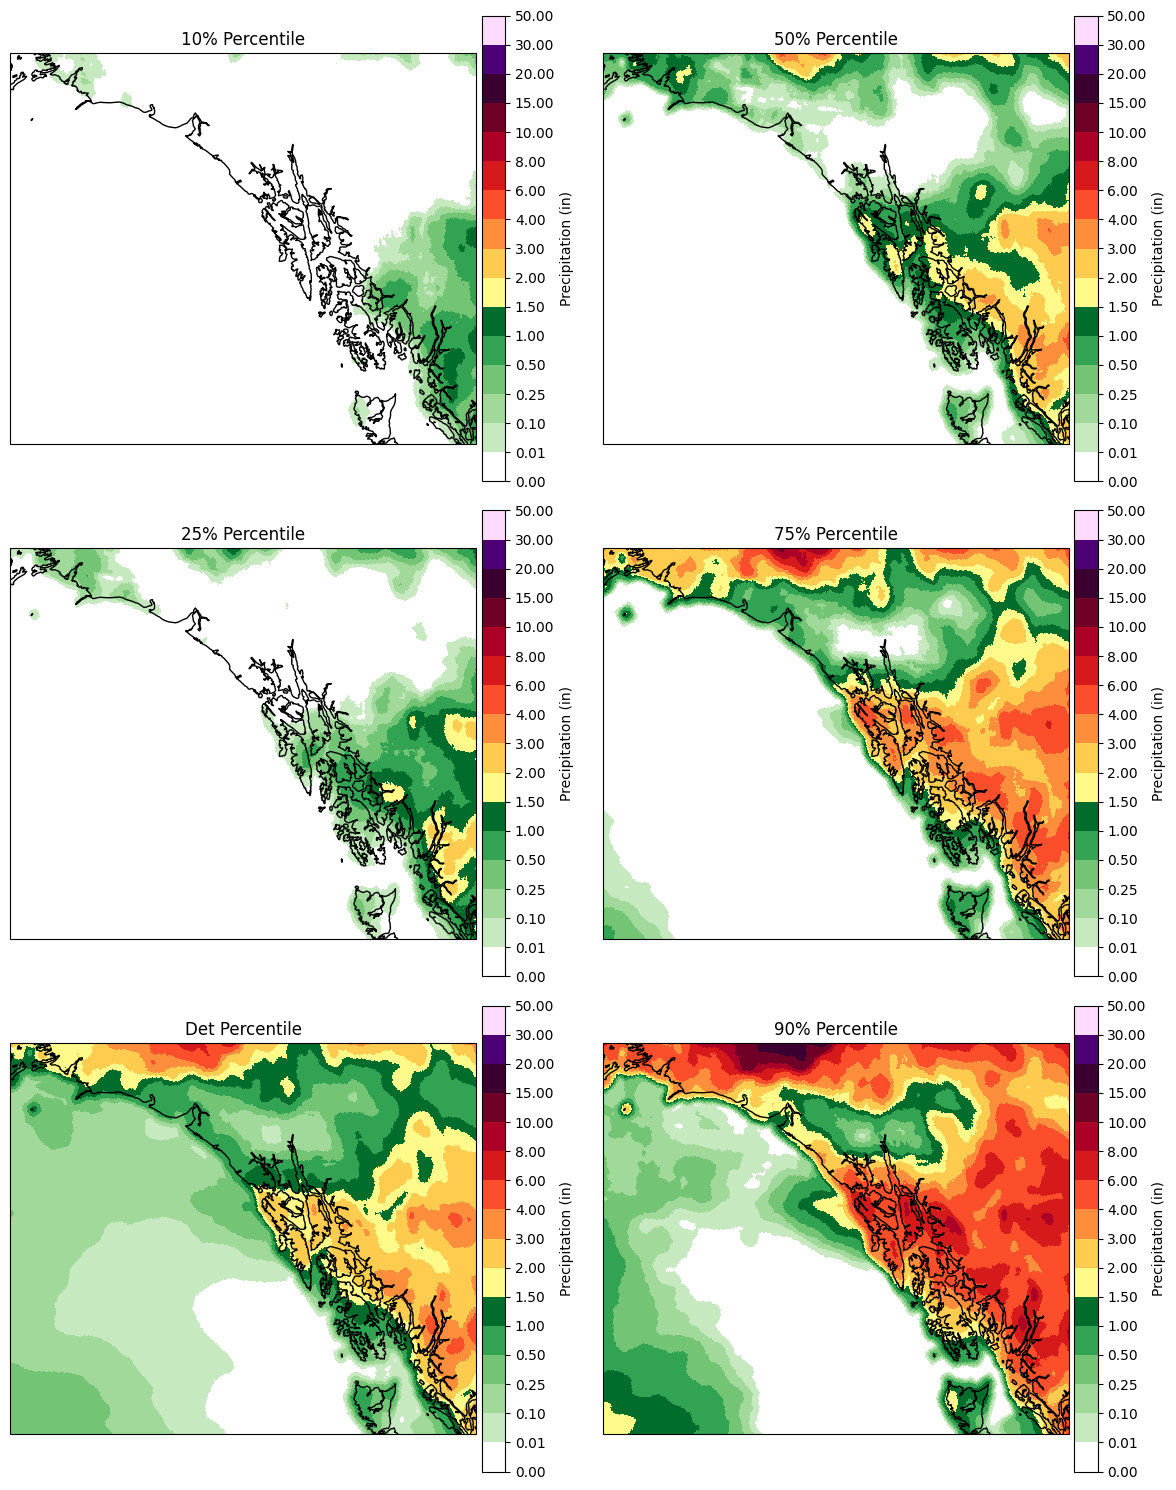

'\n\n\n  # Convert from M to In\n  Pctl_Data_UL[\'unknown\'] = Pctl_Data_UL.unknown * 39.3701\n  Pctl_Data_UM[\'unknown\'] = Pctl_Data_UM.unknown * 39.3701\n  Pctl_Data_UR[\'unknown\'] = Pctl_Data_UR.unknown * 39.3701\n  Pctl_Data_LL[\'unknown\'] = Pctl_Data_LL.unknown * 39.3701\n  Pctl_Data_LM[\'unknown\'] = Pctl_Data_LM.unknown * 39.3701\n  Pctl_Data_LR[\'unknown\'] = Pctl_Data_LR.unknown * 39.3701\n\n\n  # Convert from m/s to kts\n  if Wind_Units == "knots":\n    Wind_Multiplier = 1.94384\n  elif Wind_Units == "mph":\n    Wind_Multiplier = 2.23694\n  Pctl_Data_UL[\'i10fg\'] = Pctl_Data_UL.i10fg * Wind_Multiplier\n  Pctl_Data_UM[\'i10fg\'] = Pctl_Data_UM.i10fg * Wind_Multiplier\n  Pctl_Data_UR[\'i10fg\'] = Pctl_Data_UR.i10fg * Wind_Multiplier\n  Pctl_Data_LL[\'i10fg\'] = Pctl_Data_LL.i10fg * Wind_Multiplier\n  Pctl_Data_LM[\'i10fg\'] = Pctl_Data_LM.i10fg * Wind_Multiplier\n  Pctl_Data_LR[\'i10fg\'] = Pctl_Data_LR.i10fg * Wind_Multiplier\n\n\n  # Convert from m/s to kts\n  if Wind_Uni

In [56]:


# Base Variables
IncludeCounties = False
IncludeCities = False
IncludeMarineZones = False

Map_Fig_Size = (17, 13)
city_removal = []
local_cities_dict = {}



############################ Methods ##########################################
def make_custom_cmaps(name, colors, bounds: list = None, N: int = None):
    if N is None:
        N = len(colors)
    linear_cmap = mcolors.LinearSegmentedColormap.from_list(name, colors)
    segment_cmap = mcolors.LinearSegmentedColormap.from_list(name + "2", colors, N=N)

    # When data is NaN, set color to transparent
    linear_cmap.set_bad("#ffffff00")
    segment_cmap.set_bad("#ffffff00")

    for cm in [linear_cmap, segment_cmap]:
        mpl.colormaps.register(cmap=cm, force=True)
        mpl.colormaps.register(cmap=cm.reversed(), force=True)

    if bounds is not None:
        return (
            mcolors.Normalize(bounds.min(), bounds.max()),
            mcolors.BoundaryNorm(bounds, linear_cmap.N),
        )

class NWSPrecipitation:
    """National Weather Service precipitation amount colorbar properties.

    Also known as Qualitative Precipitation Forecast/Estimate (QPF/QPE).
    """

    name = "nws.pcp"
    units = "in"
    variable = "Precipitation"
    colors = np.array(
        [
            "#ffffff",
            "#c7e9c0",
            "#a1d99b",
            "#74c476",
            "#31a353",
            "#006d2c",
            "#fffa8a",
            "#ffcc4f",
            "#fe8d3c",
            "#fc4e2a",
            "#d61a1c",
            "#ad0026",
            "#700026",
            "#3b0030",
            "#4c0073",
            "#ffdbff",
        ]
    )
    # NWS bounds in inches
    bounds = np.array(
        [0, 0.01, 0.1, 0.25, 0.5, 1, 1.5, 2, 3, 4, 6, 8, 10, 15, 20, 30, 50]
    )
    norm, norm2 = make_custom_cmaps(name, colors, bounds)
    cmap = plt.get_cmap(name)
    cmap2 = plt.get_cmap(name + "2")
    kwargs = dict(cmap=cmap, norm=norm)
    kwargs2 = dict(cmap=cmap, norm=norm2)
    cbar_kwargs = dict(label=f"{variable} ({units})")
    cbar_kwargs2 = cbar_kwargs | dict(spacing="uniform", ticks=bounds)

#Building search strings
def build_search_string(forecast_hour, percentile, percentile_duration, element):
    if element == "Snow-Pctl" or element == "QPF-Pctl":
        if percentile_duration == '72hr':
          search_hr_range = str(forecast_hour-72) + "-" + str(forecast_hour)
        elif percentile_duration == "48hr":
          search_hr_range = str(forecast_hour-48) + "-" + str(forecast_hour)
        elif percentile_duration == "24hr":
          search_hr_range = str(forecast_hour-24) + "-" + str(forecast_hour)
    else:
        search_hr_range = str(forecast_hour)

    if element == "Snow-Pctl" and percentile == "Det":
        SearchParam = ":ASNOW:surface:" + str(search_hr_range) + " hour acc fcst"
    elif element == "Snow-Pctl" and percentile != "Det":
        SearchParam = ":ASNOW:surface:" + str(search_hr_range) + " hour acc fcst:" + percentile +" level"

    elif element == "Gust-Pctl" and percentile == "Det":
        SearchParam = ":GUST:10 m above ground:" + str(search_hr_range) + " hour fcst"
    elif elements == "Gust-Pctl" and percentile != "Det":
        SearchParam = ":GUST:10 m above ground:" + str(search_hr_range) + " hour fcst:" + percentile +" level"

    elif element == "Wind-Pctl" and percentile == "Det":
        SearchParam = ":WIND:10 m above ground:" + str(search_hr_range) + " hour fcst"
    elif element == "Wind-Pctl" and percentile != "Det":
        SearchParam = ":WIND:10 m above ground:" + str(search_hr_range) + " hour fcst:" + percentile +" level"

    elif element == "QPF-Pctl" and percentile == "Det":
        SearchParam = ":APCP:surface:36-84 hour acc fcst(?::)?$"
    elif element == "QPF-Pctl" and percentile != "Det":
        SearchParam = ":APCP:surface:" + str(search_hr_range) + " hour acc fcst:" + percentile +" level"
    return SearchParam

def download_subset_dev(remote_url, remote_file, local_filename, search_string, percentile=True):
    print("   > Downloading a subset of NBM gribs")
    local_file = os.path.join("nbm", local_filename)
    os.makedirs(os.path.dirname(local_file), exist_ok=True)

    # Download the .idx file
    idx_url = remote_url + ".idx"
    r = requests.get(idx_url)
    if not r.ok:
        print(f'     ❌ Failed to fetch index file: {idx_url} ({r.status_code} {r.reason})')
        return None

    lines = r.text.strip().split('\n')

    expr = re.compile(search_string)

    byte_ranges = {}
    if percentile:
      for n, line in enumerate(lines):
          if expr.search(line):
              parts = line.split(':')
              rangestart = int(parts[1])
              if n + 1 < len(lines):
                  next_parts = lines[n + 1].split(':')
                  rangeend = int(next_parts[1]) - 1
              else:
                  rangeend = ''

              byte_range = f'{rangestart}-{rangeend}' if rangeend else f'{rangestart}-'
              byte_ranges[byte_range] = line
    else:
      for n, line in enumerate(lines):
          if expr.search(line) and "% level" not in line and "Probability of event" not in line:
              parts = line.split(':')
              rangestart = int(parts[1])
              if n + 1 < len(lines):
                  next_parts = lines[n + 1].split(':')
                  rangeend = int(next_parts[1]) - 1
              else:
                  rangeend = ''

              byte_range = f'{rangestart}-{rangeend}' if rangeend else f'{rangestart}-'
              byte_ranges[byte_range] = line

    if not byte_ranges:
        print(f'      ❌ No matches found for [{search_string}]')
        return None

    for i, (byte_range, line) in enumerate(byte_ranges.items()):
        headers = {'Range': f'bytes={byte_range}'}
        r = requests.get(remote_url, headers=headers)
        if r.status_code not in (200, 206):
            print(f"      ❌ Failed to download byte range {byte_range}")
            return None
        with open(local_file, 'ab' if i > 0 else 'wb') as f:
            f.write(r.content)

    print(f'      ✅ Downloaded [{len(byte_ranges)}] fields → {local_file}')
    return local_file


def plot_six_panel_grib2(filenames, titles, domain_extent, projection, cmap, cbar, difference_mode=False, diffdata=[]):
    fig, axes = plt.subplots(3, 2, figsize=Map_Fig_Size, subplot_kw={'projection': projection})
    axes = axes.flatten()
    if not difference_mode:
      for i, (ax, file) in enumerate(zip(axes, filenames)):
          if not file:
              ax.set_title("Missing Data")
              ax.coastlines()
              continue

          try:
              grbs = pygrib.open(f"./nbm/{file}")
              g = grbs[1]  # Assuming subset file has one variable
              data = g.values
              lats, lons = g.latlons()
              title = titles[i]
              ax.set_extent(domain_extent, crs=ccrs.PlateCarree())
              ax.coastlines()
              cs = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), **cmap)
              ax.set_title(title)
              fig.colorbar(cs, ax=ax, orientation='vertical', pad=0.01, aspect=20, **cbar)
          except Exception as e:
              ax.set_title(f"Error: {e}")
              ax.coastlines()
              ax.add_feature(cfeature.BORDERS, linestyle=':')
              ax.add_feature(cfeature.STATES, edgecolor='gray', linestyle='--')
    else:
      for i, (ax, file, values) in enumerate(zip(axes, filenames, diffdata)):
          try:
              grbs = pygrib.open(f"./nbm/{file}")
              g = grbs[1]  # Assuming subset file has one variable
              data = values
              lats, lons = g.latlons()
              title = titles[i] + " (Diff)"
              ax.set_extent(domain_extent, crs=ccrs.PlateCarree())
              ax.coastlines()
              ax.add_feature(cfeature.BORDERS, linestyle=':')
              ax.add_feature(cfeature.STATES, edgecolor='gray', linestyle='--')
              cs = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), cmap='BrBG')
              ax.set_title(title)
              fig.colorbar(cs, ax=ax, orientation='vertical', pad=0.01, aspect=20)
          except Exception as e:
              ax.set_title(f"Error: {e}")
              ax.coastlines()
    plt.tight_layout()
    plt.show()


# Google Colab Selections

#@markdown # **Initial Forecast Info**
#@markdown <b>Select Model Run:</b><br />
nbm_init_date = "2025-07-12" #@param {type:"date"}
nbm_init_hour = 0 #@param {type:"slider", min:0, max:23, step:6}
#@markdown ###### If making a ProbSnow image, make sure to choose a 01Z/13Z model run and make sure the forecasts time ends at 00Z/06Z/12Z/18Z
Model = "NBM v4.3" #@param ['NBM v4.3', 'NBM v5.0']
#@markdown Would you like to compare versions? Check the box below
version_compare = False #@param {type:"boolean"}
##@markdown <b>Select forecast hour:</b><br />
#fhr = 21 #@param {type:"slider", min:0, max:257, step:1}
#step = np.arange(0, 49, 1, dtype=int)
#dt = str.split(Model_Date,'-')

#@markdown <b>Select Forecast Valid Time</b><br />
valid_date = "2025-07-15" #@param {type:"date"}
valid_time = 12 #@param {type:"slider", min:0, max:23, step:6}

#@markdown <b>What Percenitle Data do you want to display?</b><br />
#@markdown Wind and Gust percentiles are only available for Alaska for > NBM 5.0
elements = "QPF-Pctl" #@param ['Snow-Pctl', 'Wind-Pctl', 'Gust-Pctl', 'QPF-Pctl']
SnowQPFPctl_Duration = '48hr'  #@param ['72hr', '48hr', '24hr']
percentile_length = int(SnowQPFPctl_Duration.replace('hr', ''))
#@markdown #### Select which percentile for each section of the plot (UL = Upper left etc)
Pctl_UL = "10%" #@param ['5%', '10%', '25%', '50%','75%', '90%', '95%', 'Det']
Pctl_UM = "25%" #@param ['5%', '10%', '25%', '50%','75%', '90%', '95%', 'Det']
Pctl_UR = "Det" #@param ['5%', '10%', '25%', '50%','75%', '90%', '95%', 'Det']
Pctl_LL = "50%" #@param ['5%', '10%', '25%', '50%','75%', '90%', '95%', 'Det']
Pctl_LM = "75%" #@param ['5%', '10%', '25%', '50%','75%', '90%', '95%', 'Det']
Pctl_LR = "90%" #@param ['5%', '10%', '25%', '50%','75%', '90%', '95%', 'Det']

#@markdown # **Map: Area and Type**
#@markdown ### Select Map Info - Zoom:
Map_Zoom = "AJK" #@param ["AR", "AJK", "AFC", "AFG", "Custom"]

#@markdown ### If a Custom domain is selected, adjust the items below<br>
#@markdown Enter a custom name if you want (mainly used for filename)
custom_name = "FSD" #@param {type:"string"}
#@markdown Enter custom lat/lon bounding box if custom was selected
custom_bottom_lat =  45.47 #@param {type:"number"}
custom_left_lon = -98.45 #@param {type:"number"}
custom_top_lat = 45.32 #@param {type:"number"}
custom_right_lon = -94.97 #@param {type:"number"}

# @markdown ###If needed, adjust for map panel spacing
# @markdown ##### Edit one or more of the following values - may require some testing</i></b></font>
# @markdown <ol><li>Adjust your lat/lon boundary ranges</li>
# @markdown <li>Adjust the height and width dimensions of the figure.</li>
## @markdown <li>Adjust the plot aspect ratio ... >1 shrinks horizontal scale and vice versa.</li></ol>
## @markdown The default values of a height of 13 and a width of 17 work well with a traditional rectangle shape.
fig_height = 10 # @param {type:"raw"}
fig_height = int(fig_height)
fig_width = 17 # @param {type:"raw"}
fig_width = int(fig_width)
##plot_aspect_ratio = 1.25 # @param {type:"raw"}
##plot_aspect_ratio = float(plot_aspect_ratio)


#@markdown # **Individual Map Type Selections**
##@markdown #### <b>Do you want to include cities?</b>
#IncludeCities = False #@param ["True", "False"] {type:"raw"}
#@markdown #### <b>What units do you want the wind in?</b>
Wind_Units = 'mph'  #@param ['knots', 'mph']
#@markdown #### <b> Do you want NWS Legend?</b>
nwslegend_opt = True #@param {type:"boolean"}
#@markdown #### <b> Do you want to plot Marine Zones?</b>
IncludeMarineZones = False #@param {type:"boolean"}

## Define Map Extents

## Adding Alaska check
if Map_Zoom in ["AJK", "AFG", "AFC", "AR"]:
  domain = "ak"
elif Map_Zoom == "Custom" and custom_bottom_lat > 50:
  domain = "ak"
else:
  domain = "co"

if Map_Zoom == "AR":
    #State of AK
    Map_Fig_Size = (16, 7)
    Map_Extent = [-179.00, -129.00, 52.00, 72.00]
    IncludeCounties = True
    IncludeMarineZones = True
elif Map_Zoom == "AJK":
    #Juneau
    Map_Fig_Size = (12, 15)
    Map_Extent = [-145.00, -129.00, 53.00, 61.00]
    IncludeCounties = True
    IncludeMarineZones = True
elif Map_Zoom == "AFG":
    #Fairbanks
    Map_Fig_Size = (15, 11)
    Map_Extent = [-170.00, -141.00, 62.00, 72.00]
    IncludeCounties = True
    IncludeMarineZones = True
elif Map_Zoom == "AFC":
    #Fairbanks
    Map_Fig_Size = (16, 7)
    Map_Extent = [-160.00, -140.00, 56.00, 63.00]
    IncludeCounties = True
    IncludeMarineZones = True
elif Map_Zoom == "Custom":
    # Custom
    Map_Fig_Size = (fig_width, fig_height)
    Map_Extent = [custom_left_lon, custom_right_lon, custom_bottom_lat, custom_top_lat]
    IncludeCounties = True

# Set Projection
# Make the Central Lat/Lon in the middle of the map
cent_lon = ((Map_Extent[0] - Map_Extent[1])/2) + Map_Extent[1]
cent_lat = ((Map_Extent[3] - Map_Extent[2])/2) + Map_Extent[2]
# Assign projection
#crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
crs = ccrs.NorthPolarStereo(true_scale_latitude=60.0, central_longitude=225)

# setting colorbars
if elements == "QPF-Pctl":
  cmap = NWSPrecipitation.kwargs2
  cbar = NWSPrecipitation.cbar_kwargs2

# setting up our datetimes and checking
nbm_init = datetime.strptime(nbm_init_date,'%Y-%m-%d') + timedelta(hours=int(nbm_init_hour))
core_init = nbm_init
valid_datetime = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(hours=int(valid_time))
nbm_qmd_forecasthour = int((valid_datetime - nbm_init).total_seconds()/3600)
print(f"NBM Init Date: {nbm_init}")
print(f"NBM Valid Date: {valid_datetime}")
print(f"NBM QMD forecast hour is {nbm_qmd_forecasthour}")

if Model == "NBM v5.0" and nbm_init < datetime.strptime('2025-07-11','%Y-%m-%d'):
  print(f"No exprimental NBM data available prior to 7/11/2025. Please check your date and try again")
  raise SystemExit




if version_compare == True:
  nbm_url_base = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') \
              +"/"+nbm_init.strftime('%H')+"/"
  nbm_url_base_core = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+core_init.strftime('%Y%m%d') \
              +"/"+core_init.strftime('%H')+"/"

  nbm_url_base_exp = "https://noaa-nbm-para-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') \
              +"/"+nbm_init.strftime('%H')+"/"
  nbm_url_base_core_exp = "https://noaa-nbm-para-pds.s3.amazonaws.com/blend."+core_init.strftime('%Y%m%d') \
              +"/"+core_init.strftime('%H')+"/"

  nbm_init_filen = nbm_init.strftime('%Y%m%d') + "_" + nbm_init.strftime('%H')
  #nbm_init_filen_core = core_init.strftime('%Y%m%d') + "_" + core_init.strftime('%H')
  nbm_init_filen_core = nbm_init_filen
  print(nbm_url_base)
  print(nbm_url_base_core)
  # downloading our data
  oper_files = {}
  exp_files = {}
  for field in [Pctl_UL, Pctl_LL, Pctl_UM, Pctl_LM, Pctl_UR, Pctl_LR]:
    if (elements == "QPF-Pctl") and field == "Det":
      perc_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.{domain}.grib2'
      perc_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{domain}.{elements}_Det_subset.grib2'
      perc_url = nbm_url_base+"qmd/"+perc_file
      perc_file_exp = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.{domain}.grib2'
      perc_file_subset_exp = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{domain}.{elements}_Det_subset_exp.grib2'
      perc_url_exp = nbm_url_base_exp+"qmd/"+perc_file
      search_string = build_search_string(int(nbm_qmd_forecasthour), field, SnowQPFPctl_Duration, elements)
    elif elements == "QPF-Pctl" and field != "Det":
      perc_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.{domain}.grib2'
      perc_url = nbm_url_base+"qmd/"+perc_file
      perc_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{domain}.{elements}_{field.replace("%","")}_subset.grib2'
      perc_file_exp = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.{domain}.grib2'
      perc_url_exp = nbm_url_base_exp+"qmd/"+perc_file
      perc_file_subset_exp = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{domain}.{elements}_{field.replace("%","")}_subset_exp.grib2'
      search_string = build_search_string(int(nbm_qmd_forecasthour), field, SnowQPFPctl_Duration, elements)
    print(f"Field is: {field}")
    print(perc_file)
    print(perc_file_subset)
    print(perc_url)
    print(search_string)
    #downloading operational data
    if field != "Det":
      download_subset_dev(perc_url, perc_file, perc_file_subset, search_string)
      # downloading experimental data
      download_subset_dev(perc_url_exp, perc_file_exp, perc_file_subset_exp, search_string)
    else:
      download_subset_dev(perc_url, perc_file, perc_file_subset, search_string, percentile=False)
      #downloading experimental data
      download_subset_dev(perc_url_exp, perc_file_exp, perc_file_subset_exp, search_string, percentile=False)
    # appending filenames for later
    oper_files[field] = perc_file_subset
    exp_files[field] = perc_file_subset_exp
  #Differencing and plotting
  diff_files = []
  for op_file, exp_file in zip(oper_files, exp_files):
      # Subtract operational from experimental and save to temp
      try:
          g1 = pygrib.open(op_file)[1]
          g2 = pygrib.open(exp_file)[1]
          diff = g2.values - g1.values
          diff[g1.values.mask] = np.nan  # handle masked areas
          # Save diff to temporary numpy array for plotting (or just pass values directly)
          # For simplicity we'll just modify the plot function to handle numpy arrays
          diff_files.append(diff)
      except:
          diff_files.append(None)
  # Modified plot function would need to accept raw data too
  # setting colormaps
  plot_six_panel_grib2(diff_files, titles, Map_Extent, crs, cmap, cbar, difference_mode=True)
else:
  nbm_init_filen = nbm_init.strftime('%Y%m%d') + "_" + nbm_init.strftime('%H')
  #nbm_init_filen_core = core_init.strftime('%Y%m%d') + "_" + core_init.strftime('%H')
  nbm_init_filen_core = nbm_init_filen

  if Model == "NBM v4.3":
    nbm_url_base = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') \
                +"/"+nbm_init.strftime('%H')+"/"
    nbm_url_base_core = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+core_init.strftime('%Y%m%d') \
                +"/"+core_init.strftime('%H')+"/"
  else:
    nbm_url_base = "https://noaa-nbm-para-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') \
                +"/"+nbm_init.strftime('%H')+"/"
    nbm_url_base_core = "https://noaa-nbm-para-pds.s3.amazonaws.com/blend."+core_init.strftime('%Y%m%d') \
                +"/"+core_init.strftime('%H')+"/"
  print(nbm_url_base)
  print(nbm_url_base_core)
  # downloading our data
  oper_files = {}
  for field in [Pctl_UL, Pctl_LL, Pctl_UM, Pctl_LM, Pctl_UR, Pctl_LR]:
    if (elements == "QPF-Pctl") and field == "Det":
      perc_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.{domain}.grib2'
      perc_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{domain}.{elements}_Det_subset.grib2'
      perc_url = nbm_url_base+"qmd/"+perc_file
      search_string = build_search_string(int(nbm_qmd_forecasthour), field, SnowQPFPctl_Duration, elements)
    elif elements == "QPF-Pctl" and field != "Det":
      perc_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.{domain}.grib2'
      perc_url = nbm_url_base+"qmd/"+perc_file
      perc_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{domain}.{elements}_{field.replace("%","")}_subset.grib2'
      search_string = build_search_string(int(nbm_qmd_forecasthour), field, SnowQPFPctl_Duration, elements)
    print(f"Field is: {field}")
    print(perc_file)
    print(perc_file_subset)
    print(perc_url)
    print(search_string)
    #if not os.path.exists(f'./nbm/{perc_file_subset}'):
    #  print(f"Downloading {perc_file_subset}")
    if field != "Det":
      download_subset_dev(perc_url, perc_file, perc_file_subset, search_string)
    else:
      download_subset_dev(perc_url, perc_file, perc_file_subset, search_string, percentile=False)
    # Appending our filenames
    oper_files[field] = perc_file_subset
  # plotting our data
  nbmfiles = [filename for field, filename in oper_files.items()]
  titles = [f"{field} Percentile" for field in oper_files.keys()]
  plot_six_panel_grib2(nbmfiles, titles, Map_Extent, crs, cmap, cbar)



'''


  # Convert from M to In
  Pctl_Data_UL['unknown'] = Pctl_Data_UL.unknown * 39.3701
  Pctl_Data_UM['unknown'] = Pctl_Data_UM.unknown * 39.3701
  Pctl_Data_UR['unknown'] = Pctl_Data_UR.unknown * 39.3701
  Pctl_Data_LL['unknown'] = Pctl_Data_LL.unknown * 39.3701
  Pctl_Data_LM['unknown'] = Pctl_Data_LM.unknown * 39.3701
  Pctl_Data_LR['unknown'] = Pctl_Data_LR.unknown * 39.3701


  # Convert from m/s to kts
  if Wind_Units == "knots":
    Wind_Multiplier = 1.94384
  elif Wind_Units == "mph":
    Wind_Multiplier = 2.23694
  Pctl_Data_UL['i10fg'] = Pctl_Data_UL.i10fg * Wind_Multiplier
  Pctl_Data_UM['i10fg'] = Pctl_Data_UM.i10fg * Wind_Multiplier
  Pctl_Data_UR['i10fg'] = Pctl_Data_UR.i10fg * Wind_Multiplier
  Pctl_Data_LL['i10fg'] = Pctl_Data_LL.i10fg * Wind_Multiplier
  Pctl_Data_LM['i10fg'] = Pctl_Data_LM.i10fg * Wind_Multiplier
  Pctl_Data_LR['i10fg'] = Pctl_Data_LR.i10fg * Wind_Multiplier


  # Convert from m/s to kts
  if Wind_Units == "knots":
    Wind_Multiplier = 1.94384
  elif Wind_Units == "mph":
    Wind_Multiplier = 2.23694
  Pctl_Data_UL['si10'] = Pctl_Data_UL.si10 * Wind_Multiplier
  Pctl_Data_UM['si10'] = Pctl_Data_UM.si10 * Wind_Multiplier
  Pctl_Data_UR['si10'] = Pctl_Data_UR.si10 * Wind_Multiplier
  Pctl_Data_LL['si10'] = Pctl_Data_LL.si10 * Wind_Multiplier
  Pctl_Data_LM['si10'] = Pctl_Data_LM.si10 * Wind_Multiplier
  Pctl_Data_LR['si10'] = Pctl_Data_LR.si10 * Wind_Multiplier


  # Convert from M to In
  Pctl_Data_UL['tp'] = Pctl_Data_UL.tp * 0.0393701
  Pctl_Data_UM['tp'] = Pctl_Data_UM.tp * 0.0393701
  Pctl_Data_UR['tp'] = Pctl_Data_UR.tp * 0.0393701
  Pctl_Data_LL['tp'] = Pctl_Data_LL.tp * 0.0393701
  Pctl_Data_LM['tp'] = Pctl_Data_LM.tp * 0.0393701
  Pctl_Data_LR['tp'] = Pctl_Data_LR.tp * 0.0393701
#### Setup this line as a variable, then can add to the string for the data to grab. Example, if Basic 4-Panel, add much of first one. If Single value, add ....

# Merge the Datasets, as each | creates a separate hypercubes.
#sfc_data = xr.merge([sfc_data[0], sfc_data[1]])
#merged_data = xr.merge([init_data[0], init_data[1], init_data[2], init_data[3], init_data[4]])

# def get_xy_from_latlon for getting XY coords from 2D Lat/Lon
# Via: https://lsterzinger.medium.com/add-lat-lon-coordinates-to-goes-16-goes-17-l2-data-and-plot-with-cartopy-27f07879157f
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.latitude.data
    lon = ds.longitude.data

    x = ds.x.data
    y = ds.y.data

    x,y = np.meshgrid(x,y)

    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]

    return ((min(x), max(x)), (min(y), max(y)))

padding = 1 #1.5 # padding around domain

#print (upper_data)
# Clip Model Data to save processing/mapping time
# Clip 2D Lat/Lon
lons = (Map_Extent[0]+360.-padding, Map_Extent[1]+360.+padding)
lats = (Map_Extent[2]-padding, Map_Extent[3]+padding)

#if elements == "Snow-Pctl" or elements == "Gust-Pctl":
# Convert 2D Lat/Lon to XY Coords
((x1,x2), (y1, y2)) = get_xy_from_latlon(Pctl_Data_UL, lats, lons)
# Slice Data
final_Pctl_Data_UL = Pctl_Data_UL.sel(x=slice(x1, x2), y=slice(y1, y2))
final_Pctl_Data_UM = Pctl_Data_UM.sel(x=slice(x1, x2), y=slice(y1, y2))
final_Pctl_Data_UR = Pctl_Data_UR.sel(x=slice(x1, x2), y=slice(y1, y2))
final_Pctl_Data_LL = Pctl_Data_LL.sel(x=slice(x1, x2), y=slice(y1, y2))
final_Pctl_Data_LM = Pctl_Data_LM.sel(x=slice(x1, x2), y=slice(y1, y2))
final_Pctl_Data_LR = Pctl_Data_LR.sel(x=slice(x1, x2), y=slice(y1, y2))

###################
# Create the Image
###################

### Grab Marine Zones if Requested
if (IncludeMarineZones == True) and (marineZ_dom != Map_Zoom or marineZ_map_extent != Map_Extent):
  print('Looking for Marine Zone Shapefile...')
  if os.path.exists("/content/shp/mz18mr25.shp"):
    print("   > Marine Zone Shapefile already exists")
  else:
    try:
      print("   > Downloading Marine Zone Shapefile")
      urlretrieve("https://www.weather.gov/source/gis/Shapefiles/WSOM/mz18mr25.zip", "/content/shp/mz18mr25.zip")
      command = 'unzip /content/shp/mz18mr25.zip -d /content/shp/'
      os.system(command)
    except:
      print("     >> Unable to get Marine Zone Shapefile")

  print('   > Processing Marine Zone Shapefile')
  marineZ_shapefile_path = "/content/shp/mz18mr25.shp"
  marineZ_data = gpd.read_file(marineZ_shapefile_path)

  # Define the bounding box (xmin, ymin, xmax, ymax)
  bbox_marineZ = [Map_Extent[0]-padding, Map_Extent[2]-padding, Map_Extent[1]+padding, Map_Extent[3]+padding]  # Example bounding box

  # Create a polygon from the bounding box
  bbox_marineZ_polygon = box(*bbox_marineZ)

  # Clip the Marine Zone shapefile
  marineZ_clipped = marineZ_data.clip(bbox_marineZ_polygon)

  # Set the domain of the clipped Marine Zone data, so we can skip if the domain stays the same
  marineZ_dom = Map_Zoom
  marineZ_map_extent = Map_Extent


# @title
# Function used to create the map subplots
def plot_background(ax):
    #ax.set_extent([235., 290., 20., 55.])
    ax.set_extent(Map_Extent)
    #ax.set_extent([255., 270., 30., 50.])
    if IncludeCounties:
      ## Get data to plot state and county boundaries, roads
      counties = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_2_counties',
            scale='10m',
            facecolor='none')
      ax.add_feature(counties,edgecolor='grey',linewidth=1) #, zorder=3.4) # Line Width orig 0.25
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2) # Line Width orig 0.5
    ax.add_feature(cfeature.STATES, linewidth=2) # Line Width orig 0.5
    ax.add_feature(cfeature.BORDERS, linewidth=2) # Line Width orig 0.5
    if IncludeMarineZones:
      ax.add_geometries(marineZ_clipped.geometry, facecolor='none', edgecolor="black",linewidth=1, crs=map_crs)

    return ax

# Add Contours to make it easier to read maps
Add_Sfc_Contours = True

#Base Variables
title_y_adjust = 1


# Create Colormaps
if elements == "Snow-Pctl":
  Panel_1_range = [0, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 18,
         24, 36]
  Log_Colormap = True
  # Needed to help make sure the colortable works with low level ramp up.
  colornorm = matplotlib.colors.BoundaryNorm(boundaries=Panel_1_range, ncolors=17)
  #NWS Snow Colortable
  colors = ["#FFFFFF", "#BDD7E6", "#94C3DE", "#6BAFD6", "#3282BD", "#08519D", "#083C99", "#082694", "#FFFF9B",
            "#FFE14E", "#FFC300", "#FFA500",
            "#FE8700", "#EC4E00", "#DA1400", "#9D0000", "#690000",]
  cmap_1D = matplotlib.colors.LinearSegmentedColormap.from_list("", colors, N=17)
  extend_val = 'neither'
  Map_Type_Text = "AccumSnow"
  #Add_Sfc_Contours = False
  Map_Label = 'inches'

if elements in ["Wind-Pctl", "Gust-Pctl"]:
  if elements == "Gust-Pctl":
    Map_Type_Text = "Wind Gust"
  elif elements == "Wind-Pctl":
    Map_Type_Text = "Wind Speed"
  #Add_Sfc_Contours = False
  Map_Label = Wind_Units
  #NWS Wind Gust Colortable
#  Panel_1_range = np.arange(0, 146, 5)
#  colors = ["#103f78","#225ea8","#1d92c0","#41b7c4","#7fcdbb", "#b4d79e", "#dfff9e",
#            "#ffffa6", "#ffe873", "#ffc400", "#ffaa00", "#ffaa00",
#            "#ff5900", "#ff5900", "#ff0000", "#ff0000", "#a80000", "#a80000", "#a80000", "#a80000",
#            "#6e0000", "#6e0000", "#6e0000", "#6e0000", "#ffbee8", "#ffbee8", "#ffbee8", "#ffbee8",
#            "#ff73de"]
#  cmap_1D = matplotlib.colors.LinearSegmentedColormap.from_list("", colors, N=29)
  ### Shrunk range down to 0-80 kts
  Panel_1_range = np.arange(0, 81, 5)
  colors = ["#103f78","#225ea8","#1d92c0","#41b7c4","#7fcdbb", "#b4d79e", "#dfff9e",
            "#ffffa6", "#ffe873", "#ffc400", "#ffaa00", "#ffaa00",
            "#ff5900", "#ff5900", "#ff0000", "#ff0000",
            ]
  cmap_1D = matplotlib.colors.LinearSegmentedColormap.from_list("", colors, N=16)

if elements == "QPF-Pctl":
  Panel_1_range = [0.00, 0.01, 0.10, 0.25, 0.5, 1.0, 1.5, 2., 3., 4.,
         6., 8., 10., 15., 20., 30., 50.]
  Tick_range = [0.01, 0.10, 0.25, 0.5, 1.0, 2, 4, 8, 15, 30]
  #Log_Colormap = True
  # Needed to help make sure the colortable works with low level ramp up.
  colornorm = matplotlib.colors.BoundaryNorm(boundaries=Panel_1_range, ncolors=256)
  #NWS QPF Colortable
  colors = ["#FFFFFF", "#c7e9c0", "#a1d99b", "#74c477", "#31a353", "#006d2c", "#fff98a", "#ffcd4f",
            "#fe8d3c", "#fc4d2a", "#d61a1d", "#ad0025",
            "#700025", "#3b0030", "#3b0030", "#4d0073", "#ffdbff"]
  cmap_1D = matplotlib.colors.LinearSegmentedColormap.from_list("", colors, N=256)
  extend_val = 'neither'
  Map_Type_Text = "AccumQPF"
  #Add_Sfc_Contours = False
  Map_Label = 'inches'

# Projection
map_crs = ccrs.PlateCarree()

# Valid Time
vtime = datetime.strptime(str(final_Pctl_Data_UL.valid_time.data.astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')
vtime_txt = vtime.strftime("%m/%d/%Y %HZ")
model_time = datetime.strptime(str(final_Pctl_Data_UL.time.data.astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')
model_time_txt = model_time.strftime("%m/%d/%Y %HZ")

#### Figure Creation ####
# Create the figure and plot background on different axes
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=Map_Fig_Size, constrained_layout=True,
                          subplot_kw={'projection': crs})
#add_metpy_logo(fig, 140, 120, size='large')

axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)

## Map the data

if elements in ["Snow-Pctl", "Wind-Pctl", "Gust-Pctl", "QPF-Pctl"]:
  # Upper left plot - ProbSnow UL
  if elements == "Snow-Pctl":
    cf1 = axlist[0].contourf(final_Pctl_Data_UL.longitude, final_Pctl_Data_UL.latitude, final_Pctl_Data_UL.unknown, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                          transform=map_crs)
  elif elements == "Gust-Pctl":
    cf1 = axlist[0].contourf(final_Pctl_Data_UL.longitude, final_Pctl_Data_UL.latitude, final_Pctl_Data_UL.i10fg, Panel_1_range, cmap=cmap_1D,
                          transform=map_crs)
  elif elements == "Wind-Pctl":
    cf1 = axlist[0].contourf(final_Pctl_Data_UL.longitude, final_Pctl_Data_UL.latitude, final_Pctl_Data_UL.si10, Panel_1_range, cmap=cmap_1D,
                          transform=map_crs)
  elif elements == "QPF-Pctl":
    cf1 = axlist[0].contourf(final_Pctl_Data_UL.longitude, final_Pctl_Data_UL.latitude, final_Pctl_Data_UL.tp, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                          transform=map_crs)
    #axlist[0].clabel(cf1, fontsize=16, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
  if elements == "QPF-Pctl":
    cb1 = fig.colorbar(cf1, ax=axlist[0], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  else:
    cb1 = fig.colorbar(cf1, ax=axlist[0], ticks=Panel_1_range, orientation='horizontal', shrink=0.9, pad=0)
  cb1.set_label(Map_Label, size='large')

  # Upper middle plot - ProbSnow UM
  if elements == "Snow-Pctl":
    cf2 = axlist[1].contourf(final_Pctl_Data_UM.longitude, final_Pctl_Data_UM.latitude, final_Pctl_Data_UM.unknown, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                          transform=map_crs)
  elif elements == "Gust-Pctl":
    cf2 = axlist[1].contourf(final_Pctl_Data_UM.longitude, final_Pctl_Data_UM.latitude, final_Pctl_Data_UM.i10fg, Panel_1_range, cmap=cmap_1D,
                          transform=map_crs)
  elif elements == "Wind-Pctl":
    cf2 = axlist[1].contourf(final_Pctl_Data_UM.longitude, final_Pctl_Data_UM.latitude, final_Pctl_Data_UM.si10, Panel_1_range, cmap=cmap_1D,
                          transform=map_crs)
  elif elements == "QPF-Pctl":
    cf2 = axlist[1].contourf(final_Pctl_Data_UM.longitude, final_Pctl_Data_UM.latitude, final_Pctl_Data_UM.tp, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                          transform=map_crs)
  if elements == "QPF-Pctl":
    cb2 = fig.colorbar(cf2, ax=axlist[1], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  else:
    cb2 = fig.colorbar(cf2, ax=axlist[1], ticks=Panel_1_range, orientation='horizontal', shrink=0.9, pad=0)
  cb2.set_label(Map_Label, size='large')

  # Upper right plot - ProbSnow UR
  if elements == "Snow-Pctl":
    cf3 = axlist[2].contourf(final_Pctl_Data_UR.longitude, final_Pctl_Data_UR.latitude, final_Pctl_Data_UR.unknown, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                          transform=map_crs)
  elif elements == "Gust-Pctl":
    cf3 = axlist[2].contourf(final_Pctl_Data_UR.longitude, final_Pctl_Data_UR.latitude, final_Pctl_Data_UR.i10fg, Panel_1_range, cmap=cmap_1D,
                          transform=map_crs)
  elif elements == "Wind-Pctl":
    cf3 = axlist[2].contourf(final_Pctl_Data_UR.longitude, final_Pctl_Data_UR.latitude, final_Pctl_Data_UR.si10, Panel_1_range, cmap=cmap_1D,
                          transform=map_crs)
  elif elements == "QPF-Pctl":
    cf3 = axlist[2].contourf(final_Pctl_Data_UR.longitude, final_Pctl_Data_UR.latitude, final_Pctl_Data_UR.tp, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                          transform=map_crs)
  if elements == "QPF-Pctl":
    cb3 = fig.colorbar(cf3, ax=axlist[2], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  else:
    cb3 = fig.colorbar(cf3, ax=axlist[2], ticks=Panel_1_range, orientation='horizontal', shrink=0.9, pad=0)
  cb3.set_label(Map_Label, size='large')

  # Lower left plot - ProbSnow LL
  if elements == "Snow-Pctl":
    cf4 = axlist[3].contourf(final_Pctl_Data_LL.longitude, final_Pctl_Data_LL.latitude, final_Pctl_Data_LL.unknown, Panel_1_range, norm=colornorm, cmap=cmap_1D, transform=map_crs)
  elif elements == "Gust-Pctl":
    cf4 = axlist[3].contourf(final_Pctl_Data_LL.longitude, final_Pctl_Data_LL.latitude, final_Pctl_Data_LL.i10fg, Panel_1_range, cmap=cmap_1D, transform=map_crs)
  elif elements == "Wind-Pctl":
    cf4 = axlist[3].contourf(final_Pctl_Data_LL.longitude, final_Pctl_Data_LL.latitude, final_Pctl_Data_LL.si10, Panel_1_range, cmap=cmap_1D, transform=map_crs)
  elif elements == "QPF-Pctl":
    cf4 = axlist[3].contourf(final_Pctl_Data_LL.longitude, final_Pctl_Data_LL.latitude, final_Pctl_Data_LL.tp, Panel_1_range, norm=colornorm, cmap=cmap_1D, transform=map_crs)
  if elements == "QPF-Pctl":
    cb4 = fig.colorbar(cf4, ax=axlist[3], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  else:
    cb4 = fig.colorbar(cf4, ax=axlist[3], ticks=Panel_1_range, orientation='horizontal', shrink=0.9, pad=0)
  cb4.set_label(Map_Label, size='large')

  # Lower middle plot - ProbSnow LM
  if elements == "Snow-Pctl":
    cf5 = axlist[4].contourf(final_Pctl_Data_LM.longitude, final_Pctl_Data_LM.latitude, final_Pctl_Data_LM.unknown, Panel_1_range, norm=colornorm, cmap=cmap_1D, transform=map_crs)
  elif elements == "Gust-Pctl":
    cf5 = axlist[4].contourf(final_Pctl_Data_LM.longitude, final_Pctl_Data_LM.latitude, final_Pctl_Data_LM.i10fg, Panel_1_range, cmap=cmap_1D, transform=map_crs)
  elif elements == "Wind-Pctl":
    cf5 = axlist[4].contourf(final_Pctl_Data_LM.longitude, final_Pctl_Data_LM.latitude, final_Pctl_Data_LM.si10, Panel_1_range, cmap=cmap_1D, transform=map_crs)
  elif elements == "QPF-Pctl":
    cf5 = axlist[4].contourf(final_Pctl_Data_LM.longitude, final_Pctl_Data_LM.latitude, final_Pctl_Data_LM.tp, Panel_1_range, norm=colornorm, cmap=cmap_1D, transform=map_crs)
  if elements == "QPF-Pctl":
    cb5 = fig.colorbar(cf5, ax=axlist[4], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  else:
    cb5 = fig.colorbar(cf5, ax=axlist[4], ticks=Panel_1_range, orientation='horizontal', shrink=0.9, pad=0)
  cb5.set_label(Map_Label, size='large')

  #### Lower left plot - ProbSnow
  if elements == "Snow-Pctl":
    cf6 = axlist[5].contourf(final_Pctl_Data_LR.longitude, final_Pctl_Data_LR.latitude, final_Pctl_Data_LR.unknown, Panel_1_range, norm=colornorm, cmap=cmap_1D, transform=map_crs)
  elif elements == "Gust-Pctl":
    cf6 = axlist[5].contourf(final_Pctl_Data_LR.longitude, final_Pctl_Data_LR.latitude, final_Pctl_Data_LR.i10fg, Panel_1_range, cmap=cmap_1D, transform=map_crs)
  elif elements == "Wind-Pctl":
    cf6 = axlist[5].contourf(final_Pctl_Data_LR.longitude, final_Pctl_Data_LR.latitude, final_Pctl_Data_LR.si10, Panel_1_range, cmap=cmap_1D, transform=map_crs)
  elif elements == "QPF-Pctl":
    cf6 = axlist[5].contourf(final_Pctl_Data_LR.longitude, final_Pctl_Data_LR.latitude, final_Pctl_Data_LR.tp, Panel_1_range, norm=colornorm, cmap=cmap_1D, transform=map_crs)
  if elements == "QPF-Pctl":
    cb6 = fig.colorbar(cf6, ax=axlist[5], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  else:
    cb6 = fig.colorbar(cf6, ax=axlist[5], ticks=Panel_1_range, orientation='horizontal', shrink=0.9, pad=0)
  cb6.set_label(Map_Label, size='large')

  if Add_Sfc_Contours:
    if elements == "Snow-Pctl":
      # Contour Range.
      contourrange = [0.1, 1, 3, 6, 8, 10, 12, 15, 18, 24, 36]
      ## UL
      cf1c = axlist[0].contour(final_Pctl_Data_UL.longitude, final_Pctl_Data_UL.latitude, final_Pctl_Data_UL.unknown, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf1cl = axlist[0].clabel(cf1c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## UM
      cf2c = axlist[1].contour(final_Pctl_Data_UR.longitude, final_Pctl_Data_UM.latitude, final_Pctl_Data_UM.unknown, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf2cl = axlist[1].clabel(cf2c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## UR
      cf3c = axlist[2].contour(final_Pctl_Data_UR.longitude, final_Pctl_Data_UR.latitude, final_Pctl_Data_UR.unknown, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf3cl = axlist[2].clabel(cf3c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## LL
      cf4c = axlist[3].contour(final_Pctl_Data_LL.longitude, final_Pctl_Data_LL.latitude, final_Pctl_Data_LL.unknown, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf4cl = axlist[3].clabel(cf4c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## LM
      cf5c = axlist[4].contour(final_Pctl_Data_LM.longitude, final_Pctl_Data_LM.latitude, final_Pctl_Data_LM.unknown, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf5cl = axlist[4].clabel(cf5c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## LR
      cf6c = axlist[5].contour(final_Pctl_Data_LR.longitude, final_Pctl_Data_LR.latitude, final_Pctl_Data_LR.unknown, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf6cl = axlist[5].clabel(cf6c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
    elif elements == "Gust-Pctl":
      # Contour Range.
      contourrange = np.arange(0, 81, 5)
      ## UL
      cf1c = axlist[0].contour(final_Pctl_Data_UL.longitude, final_Pctl_Data_UL.latitude, final_Pctl_Data_UL.i10fg, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf1cl = axlist[0].clabel(cf1c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## UM
      cf2c = axlist[1].contour(final_Pctl_Data_UR.longitude, final_Pctl_Data_UM.latitude, final_Pctl_Data_UM.i10fg, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf2cl = axlist[1].clabel(cf2c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## UR
      cf3c = axlist[2].contour(final_Pctl_Data_UR.longitude, final_Pctl_Data_UR.latitude, final_Pctl_Data_UR.i10fg, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf3cl = axlist[2].clabel(cf3c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## LL
      cf4c = axlist[3].contour(final_Pctl_Data_LL.longitude, final_Pctl_Data_LL.latitude, final_Pctl_Data_LL.i10fg, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf4cl = axlist[3].clabel(cf4c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## LM
      cf5c = axlist[4].contour(final_Pctl_Data_LM.longitude, final_Pctl_Data_LM.latitude, final_Pctl_Data_LM.i10fg, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf5cl = axlist[4].clabel(cf5c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## LR
      cf6c = axlist[5].contour(final_Pctl_Data_LR.longitude, final_Pctl_Data_LR.latitude, final_Pctl_Data_LR.i10fg, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf6cl = axlist[5].clabel(cf6c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
    elif elements == "Wind-Pctl":
      # Contour Range.
      contourrange = np.arange(0, 81, 5)
      ## UL
      cf1c = axlist[0].contour(final_Pctl_Data_UL.longitude, final_Pctl_Data_UL.latitude, final_Pctl_Data_UL.si10, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf1cl = axlist[0].clabel(cf1c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## UM
      cf2c = axlist[1].contour(final_Pctl_Data_UR.longitude, final_Pctl_Data_UM.latitude, final_Pctl_Data_UM.si10, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf2cl = axlist[1].clabel(cf2c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## UR
      cf3c = axlist[2].contour(final_Pctl_Data_UR.longitude, final_Pctl_Data_UR.latitude, final_Pctl_Data_UR.si10, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf3cl = axlist[2].clabel(cf3c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## LL
      cf4c = axlist[3].contour(final_Pctl_Data_LL.longitude, final_Pctl_Data_LL.latitude, final_Pctl_Data_LL.si10, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf4cl = axlist[3].clabel(cf4c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## LM
      cf5c = axlist[4].contour(final_Pctl_Data_LM.longitude, final_Pctl_Data_LM.latitude, final_Pctl_Data_LM.si10, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf5cl = axlist[4].clabel(cf5c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)
      ## LR
      cf6c = axlist[5].contour(final_Pctl_Data_LR.longitude, final_Pctl_Data_LR.latitude, final_Pctl_Data_LR.si10, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf6cl = axlist[5].clabel(cf6c, fontsize=14, inline=1, inline_spacing=1, fmt='%.0f', rightside_up=True)

    elif elements == "QPF-Pctl":
      # Contour Range.
      contourrange = [0.01, 0.1, 0.25, 0.5, 1, 1.5, 2, 3, 4, 6, 8., 10., 15., 20., 30., 50.]
      ## UL
      cf1c = axlist[0].contour(final_Pctl_Data_UL.longitude, final_Pctl_Data_UL.latitude, final_Pctl_Data_UL.tp, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf1cl = axlist[0].clabel(cf1c, fontsize=14, inline=1, inline_spacing=1, fmt='%.2f', rightside_up=True)
      ## UM
      cf2c = axlist[1].contour(final_Pctl_Data_UR.longitude, final_Pctl_Data_UM.latitude, final_Pctl_Data_UM.tp, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf2cl = axlist[1].clabel(cf2c, fontsize=14, inline=1, inline_spacing=1, fmt='%.2f', rightside_up=True)
      ## UR
      cf3c = axlist[2].contour(final_Pctl_Data_UR.longitude, final_Pctl_Data_UR.latitude, final_Pctl_Data_UR.tp, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf3cl = axlist[2].clabel(cf3c, fontsize=14, inline=1, inline_spacing=1, fmt='%.2f', rightside_up=True)
      ## LL
      cf4c = axlist[3].contour(final_Pctl_Data_LL.longitude, final_Pctl_Data_LL.latitude, final_Pctl_Data_LL.tp, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf4cl = axlist[3].clabel(cf4c, fontsize=14, inline=1, inline_spacing=1, fmt='%.2f', rightside_up=True)
      ## LM
      cf5c = axlist[4].contour(final_Pctl_Data_LM.longitude, final_Pctl_Data_LM.latitude, final_Pctl_Data_LM.tp, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf5cl = axlist[4].clabel(cf5c, fontsize=14, inline=1, inline_spacing=1, fmt='%.2f', rightside_up=True)
      ## LR
      cf6c = axlist[5].contour(final_Pctl_Data_LR.longitude, final_Pctl_Data_LR.latitude, final_Pctl_Data_LR.tp, levels=contourrange, colors='black',
                            linewidths=0.5, linestyles='solid', transform=map_crs)
      cf6cl = axlist[5].clabel(cf6c, fontsize=14, inline=1, inline_spacing=1, fmt='%.2f', rightside_up=True)

if IncludeCities:
  ## Citites Addition - https://gist.github.com/cbur24/9122c763301f6de1d6e1fc39763c2444
  #get town locations
  shp_fn = shpreader.natural_earth(resolution='10m', category='cultural', name='populated_places')
  cities_shp = shpreader.Reader(shp_fn)
  cities_xy = [pt.coords[0] for pt in cities_shp.geometries()]
  cities_x, cities_y = list(zip(*cities_xy))

  #get town names
  towns = cities_shp.records()
  names_en = []
  for town in towns:
      names = town.attributes['NAME']
      names_en.append(names)

  #create data frame and index by the region of the plot
  all_towns = pd.DataFrame({'names_en': names_en, 'x':cities_x, 'y':cities_y})
  ## Adjusted Long extent to trim cities along edge of the map.
  region_towns = all_towns.query('@Map_Extent[0] < x < @Map_Extent[1]-0.5')
  region_towns = region_towns.query('@Map_Extent[2] < y < @Map_Extent[3]')

  ## Set Font Color
  fontcolor = "black"
  #if Img_Data == "Channel" and Channel == "07":
  #    fontcolor = "black"
  ## Remove Extra Cities from certain locations
  for c in city_removal:
      region_towns = region_towns.drop(region_towns[region_towns.names_en == c].index)
#        print ("!!!!")
#        print (region_towns)
  ## Add Extra Cities
  local_cities_df = pd.DataFrame(local_cities_dict)
  region_towns = pd.concat([region_towns, local_cities_df], ignore_index = True)
  region_towns.reset_index()
#        if Custom_Cities == "Yes":
#            if len(labels):
#            #    print ("test")
#                ax.plot(city_lons, city_lats, marker='o', color=fontcolor, zorder=7, markersize=6, linestyle='None', transform=ccrs.Geodetic())
#                for label, xpt, ypt, x_offset, y_offset in zip(labels, city_lons, city_lats, x_offsets, y_offsets):
#                    ax.text(xpt+x_offset , ypt+y_offset, label, fontsize=15, fontweight='bold', zorder=8, color=fontcolor, transform=ccrs.Geodetic())
#        else:
  for z in [0, 1, 2, 3, 4, 5]:
    axlist[z].scatter(region_towns.x.values, region_towns.y.values, c =fontcolor, marker= 'o', s=15, transform=ccrs.PlateCarree(), zorder=7)
    transform_mpl = ccrs.PlateCarree()._as_mpl_transform(axlist[z]) #this is a work-around to transform xy coords in ax.annotate
    for i, txt in enumerate(region_towns.names_en):
#      for z in [0, 1, 2, 3]:
      axlist[z].annotate(txt, (region_towns.x.values[i], region_towns.y.values[i]+0.05), xycoords=transform_mpl, fontsize=15, fontweight='bold', zorder=8, color=fontcolor, ha='center')


# Loop to add each panel title
if elements in ["Snow-Pctl", "QPF-Pctl"]:
  if elements == "Snow-Pctl":
    pctl_type_text = 'Snow'
  else:
    pctl_type_text = 'QPF'
  if Pctl_UL == "Det":
    Pctl_Text_UL = ' - Deterministic ' + SnowQPFPctl_Duration + ' ' + pctl_type_text
  else:
    Pctl_Text_UL = ' - ' + SnowQPFPctl_Duration + ' ' + pctl_type_text + ' Pctl: ' + Pctl_UL
  if Pctl_UM == "Det":
    Pctl_Text_UM = ' - Deterministic ' + SnowQPFPctl_Duration + ' ' + pctl_type_text
  else:
    Pctl_Text_UM = ' - ' + SnowQPFPctl_Duration + ' ' + pctl_type_text + ' Pctl: ' + Pctl_UM
  if Pctl_UR == "Det":
    Pctl_Text_UR = ' - Deterministic ' + SnowQPFPctl_Duration + ' ' + pctl_type_text
  else:
    Pctl_Text_UR = ' - ' + SnowQPFPctl_Duration + ' ' + pctl_type_text + ' Pctl: ' + Pctl_UR
  if Pctl_LL == "Det":
    Pctl_Text_LL = ' - Deterministic ' + SnowQPFPctl_Duration + ' ' + pctl_type_text
  else:
    Pctl_Text_LL = ' - ' + SnowQPFPctl_Duration + ' ' + pctl_type_text + ' Pctl: ' + Pctl_LL
  if Pctl_LM == "Det":
    Pctl_Text_LM = ' - Deterministic ' + SnowQPFPctl_Duration + ' ' + pctl_type_text
  else:
    Pctl_Text_LM = ' - ' + SnowQPFPctl_Duration + ' ' + pctl_type_text + ' Pctl: ' + Pctl_LM
  if Pctl_LR == "Det":
    Pctl_Text_LR = ' - Deterministic ' + SnowQPFPctl_Duration + ' ' + pctl_type_text
  else:
    Pctl_Text_LR = ' - ' + SnowQPFPctl_Duration + ' ' + pctl_type_text + ' Pctl: ' + Pctl_LR
elif elements == "Gust-Pctl":
  if Pctl_UL == "Det":
    Pctl_Text_UL = ' - Deterministic Wind Gust'
  else:
    Pctl_Text_UL = ' - ' + Pctl_UL[:-1] + 'th Percentile Wind Gust'
  if Pctl_UM == "Det":
    Pctl_Text_UM = ' - Deterministic Wind Gust'
  else:
    Pctl_Text_UM = ' - ' + Pctl_UM[:-1] + 'th Percentile Wind Gust'
  if Pctl_UR == "Det":
    Pctl_Text_UR = ' - Deterministic Wind Gust'
  else:
    Pctl_Text_UR = ' - ' + Pctl_UR[:-1] + 'th Percentile Wind Gust'
  if Pctl_LL == "Det":
    Pctl_Text_LL = ' - Deterministic Wind Gust'
  else:
    Pctl_Text_LL = ' - ' + Pctl_LL[:-1] + 'th Percentile Wind Gust'
  if Pctl_LM == "Det":
    Pctl_Text_LM = ' - Deterministic Wind Gust'
  else:
    Pctl_Text_LM = ' - ' + Pctl_LM[:-1] + 'th Percentile Wind Gust'
  if Pctl_LR == "Det":
    Pctl_Text_LR = ' - Deterministic Wind Gust'
  else:
    Pctl_Text_LR = ' - ' + Pctl_LR[:-1] + 'th Percentile Wind Gust'
elif elements == "Wind-Pctl":
  if Pctl_UL == "Det":
    Pctl_Text_UL = ' - Deterministic Wind Speed'
  else:
    Pctl_Text_UL = ' - ' + Pctl_UL[:-1] + 'th Percentile Wind Speed'
  if Pctl_UM == "Det":
    Pctl_Text_UM = ' - Deterministic Wind Speed'
  else:
    Pctl_Text_UM = ' - ' + Pctl_UM[:-1] + 'th Percentile Wind Speed'
  if Pctl_UR == "Det":
    Pctl_Text_UR = ' - Deterministic Wind Speed'
  else:
    Pctl_Text_UR = ' - ' + Pctl_UR[:-1] + 'th Percentile Wind Speed'
  if Pctl_LL == "Det":
    Pctl_Text_LL = ' - Deterministic Wind Speed'
  else:
    Pctl_Text_LL = ' - ' + Pctl_LL[:-1] + 'th Percentile Wind Speed'
  if Pctl_LM == "Det":
    Pctl_Text_LM = ' - Deterministic Wind Speed'
  else:
    Pctl_Text_LM = ' - ' + Pctl_LM[:-1] + 'th Percentile Wind Speed'
  if Pctl_LR == "Det":
    Pctl_Text_LR = ' - Deterministic Wind Speed'
  else:
    Pctl_Text_LR = ' - ' + Pctl_LR[:-1] + 'th Percentile Wind Speed'
panel_title_text = [Pctl_Text_UL, Pctl_Text_UM, Pctl_Text_UR, Pctl_Text_LL, Pctl_Text_LM, Pctl_Text_LR]
#if Map_Zoom == "Dakotas":
title_y_adjust = 1.045
for i in range(0,6):
  axlist[i].set_title(model_time_txt + ' ' + Model.upper() + panel_title_text[i], loc='left', fontweight='bold', fontsize=12, y=title_y_adjust)
  axlist[i].set_title('\nFcst Hr: ' + str(fhr) + ' - Valid: {}'.format(vtime_txt), loc='right')

# Set height padding for plots
fig.set_constrained_layout_pads(w_pad=0., h_pad=0.1, hspace=0., wspace=0.)

# Add Credits
if nwslegend_opt:
  plt.figtext(0.96, 0.00, 'Image via National Weather Service', horizontalalignment='right',
            fontweight='bold', fontsize=10, color='white',
            path_effects=[pe.withStroke(linewidth=3, foreground="black")])
else:
  plt.figtext(0.99, 0.00, 'Image via Steven Fleegel', horizontalalignment='right',
            fontweight='bold', fontsize=10, color='white',
            path_effects=[pe.withStroke(linewidth=3, foreground="black")])

# Tighten up the plot
#plt.tight_layout()

#Save Image

if Map_Zoom == "Custom" and custom_name != "":
  domain_name = custom_name
else:
  domain_name = Map_Zoom

Img_Name = "NBM_6Panel_"+ elements +"_" + domain_name + "_Run-" + Model_Date + "_" + str(Model_Run)[:-3] + "Z_F" + str(fhr) + ".png"
plt.savefig(f"{Img_Name}", dpi = 150, facecolor='w', bbox_inches = "tight")

# Display the plot
plt.show()

'''

In [ ]:
#@markdown # **Individual Point Output**
#@markdown #### <b> After creating a graphic, input a Lat/Lon and run this cell to get the percentile values at a point for your percentile selections.</b>
Point_Lat =  45.47 #@param {type:"number"}
Point_Lon = -98.45 #@param {type:"number"}

# Only edit the lat/lon on the next two lines, then click the "Play" button
#Point_Lat = 45.47
#Point_Lon = -98.45

### Don't adjust the rest of the code.
Point_Lon_Final = 360 + Point_Lon

# Lookup table for Percentile
Pctl_Lookup_Table = {"Snow-Pctl" : "unknown", "QPF-Pctl" : "tp", "Wind-Pctl" : "si10", "Gust-Pctl" : "i10fg", }

# First, find the index of the grid point nearest a specific lat/lon.
abslat = np.abs(Pctl_Data_UL.latitude-Point_Lat)
abslon = np.abs(Pctl_Data_UL.longitude-Point_Lon_Final)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

# Now I can use that index location to get the values at the x/y diminsion
point_UL = Pctl_Data_UL.sel(x=yloc, y=xloc)
point_UM = Pctl_Data_UM.sel(x=yloc, y=xloc)
point_UR = Pctl_Data_UR.sel(x=yloc, y=xloc)
point_LL = Pctl_Data_LL.sel(x=yloc, y=xloc)
point_LM = Pctl_Data_LM.sel(x=yloc, y=xloc)
point_LR = Pctl_Data_LR.sel(x=yloc, y=xloc)

if elements in ["Snow-Pctl", "QPF-Pctl"]:
  Point_Text_Element = panel_title_text[i][:-5]
else:
  Point_Text_Element = " Wind"
  if elements == "Gust-Pctl":
    Point_Text_Element+= " Gust"
print (model_time_txt + ' ' + Model.upper() + Point_Text_Element + " \nFcst Hr: " + str(fhr) + " - Valid: {}".format(vtime_txt) )
print ("Percentile Values for " + str(Point_Lat) + ", " + str(Point_Lon))
print (Pctl_UL + ": ", round(point_UL[Pctl_Lookup_Table[elements]].item(),2) )
print (Pctl_UM + ": ", round(point_UM[Pctl_Lookup_Table[elements]].item(),2) )
print (Pctl_UR + ": ", round(point_UR[Pctl_Lookup_Table[elements]].item(),2) )
print (Pctl_LL + ": ", round(point_LL[Pctl_Lookup_Table[elements]].item(),2) )
print (Pctl_LM + ": ", round(point_LM[Pctl_Lookup_Table[elements]].item(),2) )
print (Pctl_LR + ": ", round(point_LR[Pctl_Lookup_Table[elements]].item(),2) )

02/07/2025 01Z NBM - 48hr Snow Pctl 
Fcst Hr: 59 - Valid: 02/09/2025 12Z
Percentile Values for 45.47, -98.45
10%:  2.01
25%:  2.8
50%:  3.58
75%:  4.88
90%:  6.18
95%:  6.5


# **Zip up image files for download**
This will zip all .png files in the folder to the left for download.

In [ ]:
!zip -r /content/NBM_Data.zip /content/*.png

  adding: content/NBM_6Panel_Gust-Pctl_Dakotas_Run-2025-01-14_0Z_F78.png (deflated 1%)
  adding: content/NBM_6Panel_Gust-Pctl_Dakotas_Run-2025-01-14_0Z_F81.png (deflated 0%)
  adding: content/NBM_6Panel_Gust-Pctl_Dakotas_Run-2025-01-14_0Z_F84.png (deflated 0%)
  adding: content/NBM_6Panel_Gust-Pctl_Dakotas_Run-2025-01-14_0Z_F87.png (deflated 1%)
  adding: content/NBM_6Panel_Gust-Pctl_Dakotas_Run-2025-01-14_0Z_F90.png (deflated 1%)
  adding: content/NBM_6Panel_Gust-Pctl_Dakotas_Run-2025-01-14_0Z_F93.png (deflated 1%)
  adding: content/NBM_6Panel_Gust-Pctl_Dakotas_Run-2025-01-14_0Z_F96.png (deflated 1%)
  adding: content/NBM_6Panel_Gust-Pctl_Dakotas_Run-2025-01-14_0Z_F99.png (deflated 1%)
  adding: content/NBM_6Panel_Gust-Pctl_Dakotas_Run-2025-01-15_0Z_F54.png (deflated 1%)
  adding: content/NBM_6Panel_Gust-Pctl_Dakotas_Run-2025-01-15_0Z_F57.png (deflated 0%)
  adding: content/NBM_6Panel_Gust-Pctl_Dakotas_Run-2025-01-15_0Z_F60.png (deflated 0%)
  adding: content/NBM_6Panel_Gust-Pctl_Dako

# **Remove Images in Folder to the left**
If you're saving a lot of images and want to clear the folder to the left, run the section below.

In [ ]:
!rm /content/*.png
!rm /content/*.zip

**Change Log**

**V1.23** - Added option to display a list of percentiles for a Lat/Lon point. <br>
**V1.22** - Added Marine Zones to the Great Lakes map zooms. <br>
**V1.21** - Fixed issue with Wind Percentiles and added Great Lakes Map Zooms (thanks Dan T!).  <br>
**V1.2** - Added Wind Percentiles.  <br>
**V1.1** - Added QPF Percentiles.  <br>
**V1.02** - Fixed issue with ecCodes 2.39.0 and Herbie <br>
**V1.01** - Added option to Zip files and remove when creating multiple.  <br>
**V1.0** - Original Release <br>